# 13. MODFLOW 6 Transport

:::{admonition} Course Website
[Link to Course Website](http://54.243.252.9/ce-5364-webroot/) 
:::

This section introduces **MODFLOW 6 Groundwater Transport (GWT)** by **replicating a classic MT3DMS benchmark** from the 1990s. We follow the MF6 example notebook for MT3DMS Problem 9 and adapt it so you can run it locally:
<https://modflow6-examples.readthedocs.io/en/master/_notebooks/ex-gwt-mt3dms-p09.html>

**Why this example?**  
The ten MT3DMS problems (manual, 1999; pp. ~130+) are widely used verification cases. By reproducing **Example 9** with MF6-GWT, we (i) learn the MF6 transport workflow, (ii) check that MF6 matches a legacy standard, and (iii) establish plotting/analysis patterns we will reuse later.

**Goals**
- Build a coupled **GWF (flow) + GWT (transport)** model with FloPy.  
- Specify advection/dispersion/decay parameters and boundary/source terms.  
- Run MF6 and compare plume snapshots or breakthrough curves with the MT3DMS reference.  
- Adopt a reusable workflow (model build → run → postprocess → verify).

> The linked source shows MF6 and MT3DMS producing **comparable results** for this case.

:::{note}
**About portability and setup**

A straight copy-paste from the online notebook often fails on a new machine because of **executable paths** and minor API differences. In this notebook, small edits were required to:
- Locate compiled binaries (e.g., `mf6`, `mp7`, `mt3d-usgs`) via environment/path checks.
- Adjust one object name to match current FloPy/MF6 versions.
- Quiet nonessential warnings for a cleaner teachable notebook.

If your install mirrors the reference repo’s layout and binary locations, the example may run as-is. Otherwise, use a robust binary lookup (e.g., `flopy.which("mf6")`) and set workspaces explicitly. Our goal here is to **reverse-engineer the workflow and plotting tools**; later sections focus on modeling and scenario design.
:::

:::{warning}
**Local build notes (specific to this machine)**

The next two cells (path reset + warnings filter) are **machine-specific**. The reset is used so the notebook can rebuild cleanly for caching/typesetting. Suppressing deprecation warnings keeps the narrative readable.

```python
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
```
:::

# MF6-GWT compared to MT3DMS Example 9

In [1]:
%reset -f

In [2]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The script generates a lot of output that are suppressed by a `;`  Comment the character out to re-enable full output (which is damn helpful for debugging the script!)
:::

## Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [3]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The code block above loads various modules into the environment; they must exist and be loaded into the kernel - if not you get a warning "Module Not Found" and will have to install into the kernel (i.e. `pip -m install module`, or the `conda` equivalent
Filter warnings repeated to achieve "for sure ..." that the filter is applied.  By design the filter will not stop ERRORS, and warnings issued within functions will still display, but it will address one annoying deprecation error.
:::

### Define parameters

Define model units, parameters and other settings.

In [4]:
# Model units
length_units = "meters"
time_units = "seconds"

# Model parameters
nlay = 1  # Number of layers
nrow = 18  # Number of rows
ncol = 14  # Number of columns
delr = 100.0  # Column width ($m$)
delc = 100.0  # Row width ($m$)
delz = 10.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.3  # Porosity
k1 = 1.474e-4  # Horiz. hyd. conductivity of medium grain material ($m/sec$)
k2 = 1.474e-7  # Horiz. hyd. conductivity of fine grain material ($m/sec$)
inj = 0.001  # Injection well rate ($m^3/sec$)
ext = -0.0189  # Extraction well pumping rate ($m^3/sec$)
al = 20.0  # Longitudinal dispersivity ($m$)
trpt = 0.2  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)
perlen = 2.0  # Simulation time ($years$)

# Additional model input
hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
hk[:, 5:8, 1:8] = k2
laytyp = icelltype = 0

# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions
# MF2K5 pumping info
qwell1 = 0.001
qwell2 = -0.0189
welspd = {0: [[0, 3, 6, qwell1], [0, 10, 6, qwell2]]}  # Well pumping info for MF2K5
cwell1 = 57.87
cwell0 = 0.0
spd = {
    0: [[0, 3, 6, cwell1, 2], [0, 10, 6, cwell0, 2]],
    1: [[0, 3, 6, cwell0, 2], [0, 10, 6, cwell0, 2]],
}  # Well info 4 MT3D
# MF6 pumping information
wellist_sp1 = []
#                   (k,  i, j),   flow,  conc
wellist_sp1.append([(0, 3, 6), qwell1, cwell1])  # Injection well
wellist_sp1.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
#
wellist_sp2 = []
#                   (k,  i, j),   flow,  conc
wellist_sp2.append([(0, 3, 6), qwell1, cwell0])  # Injection well
wellist_sp2.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
spd_mf6 = {0: wellist_sp1, 1: wellist_sp2}

# Transport related
sconc = 0.0
ath1 = al * trpt
dmcoef = 0.0  # m^2/s
# Time variables
perlen = [365.0 * 86400, 365.0 * 86400]
steady = [False, False]
nper = len(perlen)
nstp = [365, 365]
tsmult = [1.0, 1.0]
#
sconc = 0.0
c0 = 0.0
botm = [top - delz]
mixelm = -1

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

The code block above loads variables and constants to define the actual model.  We will focus on how to conceptualize later on.

## Model setup

Define functions to build models, write input files, and run the simulation.

**Groundwater Flow Package Build**

In [5]:
# Workspace and Executibles
#binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
#workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6-ex1" # location on MY computer to store files this example (directory must already exist)
#workarea = workspace # location on MY computer to store files this example (directory must already exist)

binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on AWS computer of the compiled modflow program
workarea = "/home/sensei/ce-5364-webroot/mfexperiments/mf6-ex1" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name(s)
name = "mt3d_ex09"
gwfname = "gwf-" + name
gwtname = "gwt-" + name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name="sim-" + name, exe_name=binary, version="mf6", sim_ws=workarea
)
####### CREATED "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mt3d_example9"

The code block above sets paths to the binary (in my case a compiled MODFLOW6 object located at `/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/`.   The binary was built using the `make` utility operating on the `makefile` contained in `~path_to_source/mf6.4.1_linux/make`

In [6]:
####### Instantiating MODFLOW 6 time discretization ########
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units);
## delete ";" in above line at end to show full output

The code block above sets the time stepping structure.  Units are supplied in the model constants already created. `perlen` is a list of period length in time units of a stress period. , `nstp` is a list of the number of time steps per period, tsmult is a list of time step multipliers.

In [7]:
####### Instantiating MODFLOW 6 groundwater flow model ########
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(gwfname)
# create MODFLOW6 flow model framework
gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True, model_nam_file=model_nam_file);
## delete ";" in above line at end to show full output

The code block above sets prefix of the flow model file names.  

In [8]:
###### Instantiating MODFLOW 6 solver for flow model #######
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwfname}.ims",
    )
sim.register_ims_package(imsgwf, [gwf.name]);
## delete ";" in above line at end to show full output

The code block above sets the iteration and solver parameters.  URL to documents is included in the comments.

In [9]:
###### Instantiating MODFLOW 6 discretization package ######
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    );
## delete ";" in above line at end to show full output

The code block above sets the spatial structure.  We must supply layers, rows, columns, and spacing between rows and columns (i.e. how big is a pixel).  Vertical spacing computed as 

$$\Delta z = \frac{\text{top}-\text{bottom}}{\text{number of layers}}$$

In [10]:
###### Instantiating MODFLOW 6 initial conditions package for flow model #######
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, :] = 250.0
xc = gwf.modelgrid.xcellcenters
for j in range(ncol):
    strt[0, -1, j] = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic");
## delete ";" in above line at end to show full output

The code block above sets the initial conditions. The top row in this example is set to 250, the bottom row from 20 to 52.5 in steps of 2.5.  If there are other starting conditions either write code or read from a file, or hard-code the constants as needed.

In [11]:
# Instantiating MODFLOW 6 node-property flow package
flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=hk,
    k33=hk,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    );
## delete ";" in above line at end to show full output

The code block above sets the node-property data (its like the old BCF package).  Here we supply that we want to save sp. discharge (needed for transport), the k, and k33 values the same implies NOT unconfined sustem.

In [12]:
# Instantiate storage package
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.0e-05);
## delete ";" in above line at end to show full output

The code block above sets the storage properties for transient simulations.

In [13]:
# Instantiating MODFLOW 6 constant head package
# MF6 constant head boundaries:
chdspd = []
# Loop through the top & bottom sides.
for j in np.arange(ncol):
        #               l,  r, c,  head, conc
    chdspd.append([(0, 0, j), 250.0, 0.0])  # Top boundary
    hd = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
    chdspd.append([(0, 17, j), hd, 0.0])  # Bottom boundary
chdspd = {0: chdspd}

flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    );
## delete ";" in above line at end to show full output

The code block above sets the constant head boundary conditions.

In [14]:
# Instantiate the wel package
flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=spd_mf6,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="WEL-1",
    filename=f"{gwfname}.wel",
    );
## delete ";" in above line at end to show full output

The code block above sets activates the well paclage

In [15]:
# Instantiating MODFLOW 6 output control package for flow model
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    );
## delete ";" in above line at end to show full output

The code block above defines parts of output control.



**Transport Package Building**

In [16]:
###### Instantiating MODFLOW 6 groundwater transport package ##########
gwtname = "gwt-" + name
gwt = flopy.mf6.MFModel(
    sim,
    model_type="gwt6",
    modelname=gwtname,
    model_nam_file=f"{gwtname}.nam",
    )#;
## delete ";" in above line at end to show full output
gwt.name_file.save_flows = True

The code block above sets prefix of the transport model file names.  

In [17]:
# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwtname}.ims",
    )
sim.register_ims_package(imsgwt, [gwt.name]);
## delete ";" in above line at end to show full output

The code block above sets the iteration and solver parameters.  

In [18]:
###### Instantiating MODFLOW 6 transport discretization package #####
flopy.mf6.ModflowGwtdis(
    gwt,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    );
## delete ";" in above line at end to show full output

The code block above sets the spatial structure.  We must supply layers, rows, columns, and spacing between rows and columns (i.e. how big is a pixel).  Vertical spacing computed as 

$$\Delta z = \frac{\text{top}-\text{bottom}}{\text{number of layers}}$$

Typically will be same as flow model.

In [19]:
# Instantiating MODFLOW 6 transport initial concentrations
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic");
## delete ";" in above line at end to show full output

Initial conditions (concentration) for transport.

In [20]:
    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv");
## delete ";" in above line at end to show full output

Advective transport methods.  In this example upwind formulation with Total Variation Diminishing (TVD) flux limiters. A TVD formulation is a numerical method designed to ensure that the computed solution to a transport equation does not exhibit non-physical oscillations or spurious oscillations, particularly near discontinuities or steep gradients. This flux limitation is crucial for maintaining the accuracy and stability of the numerical solution in simulations involving advective transport, such as contaminant transport in groundwater models.

Key points about TVD formulations:

- Purpose: TVD methods aim to prevent the introduction of oscillations or artifacts in the numerical solution that can arise from the discretization of the transport equation, especially in regions with sharp gradients or discontinuities.

- Techniques: TVD schemes use various strategies to achieve this, including modifying the standard discretization approaches, using flux limiters, or applying specific numerical flux functions that ensure the total variation of the solution is not increased.

- Applications: TVD methods are commonly used in computational fluid dynamics, meteorology, and environmental modeling where accurate representation of transport processes is essential. In groundwater modeling, TVD formulations help to ensure realistic simulation of contaminant transport and avoid numerical artifacts that could lead to incorrect predictions.

- Examples: Common TVD schemes include the TVD Runge-Kutta methods, TVD Lax-Wendroff schemes, and various other high-resolution schemes that incorporate flux limiters or other modifications to ensure total variation diminishing properties.

In [21]:
# Instantiating MODFLOW 6 transport dispersion package
if al != 0:
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al, # longitudinal
        ath1=ath1, # transverse
        filename=f"{gwtname}.dsp",
        );
## delete ";" in above line at end to show full output

This code iniatiates the dispersion method with Longitudinal dispersivity  $a_l = 20.0~m$ and the ratio of horizontal transverse to longitudinal dispersivity $trpt = 0.2$  In the above script $a_t = trpt \times a_l$

In [22]:
# Instantiating MODFLOW 6 transport mass storage package
flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=prsity,
    first_order_decay=False,
    decay=None,
    decay_sorbed=None,
    sorption=None,
    bulk_density=None,
    distcoef=None,
    filename=f"{gwtname}.mst",
    );
## delete ";" in above line at end to show full output

Code block sets adsorbtion/desorbtion and 1st order decay terms if any.

In [23]:
# Instantiating MODFLOW 6 transport source-sink mixing package
sourcerecarray = [
    ("WEL-1", "AUX", "CONCENTRATION"),
    ("CHD-1", "AUX", "CONCENTRATION"),
    ]
flopy.mf6.ModflowGwtssm(
    gwt,
    sources=sourcerecarray,
    print_flows=True,
    filename=f"{gwtname}.ssm",
    );
## delete ";" in above line at end to show full output

Code above manages source/sink mixing terms.

In [24]:
# Instantiating MODFLOW 6 transport output control package
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwtname}.cbc",
    concentration_filerecord=f"{gwtname}.ucn",
    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    filename=f"{gwtname}.oc",
    );
## delete ";" in above line at end to show full output

Output control for transport

In [25]:
# Instantiating MODFLOW 6 flow-transport exchange mechanism
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwfname,
    exgmnameb=gwtname,
    filename=f"{name}.gwfgwt",
    );
## delete ";" in above line at end to show full output

Code above manages how flow (gwf) and transport (gwt) exchange information at each time step.

**Generate the Files**

In [26]:
sim.write_simulation(silent=True)

**Running the Model** 

In [27]:
#success, buff = sim.run_simulation(silent=False, report=True)#Verbose output
success, buff = sim.run_simulation(silent=True, report=True)#Suppress output
assert success, pformat(buff)

### Plotting results

Plotting model results.

:::{note}
A lot of reverse engineering to produce plots; am positive this is not the best way to make the plots, but was using the original example link as a go-by.
:::

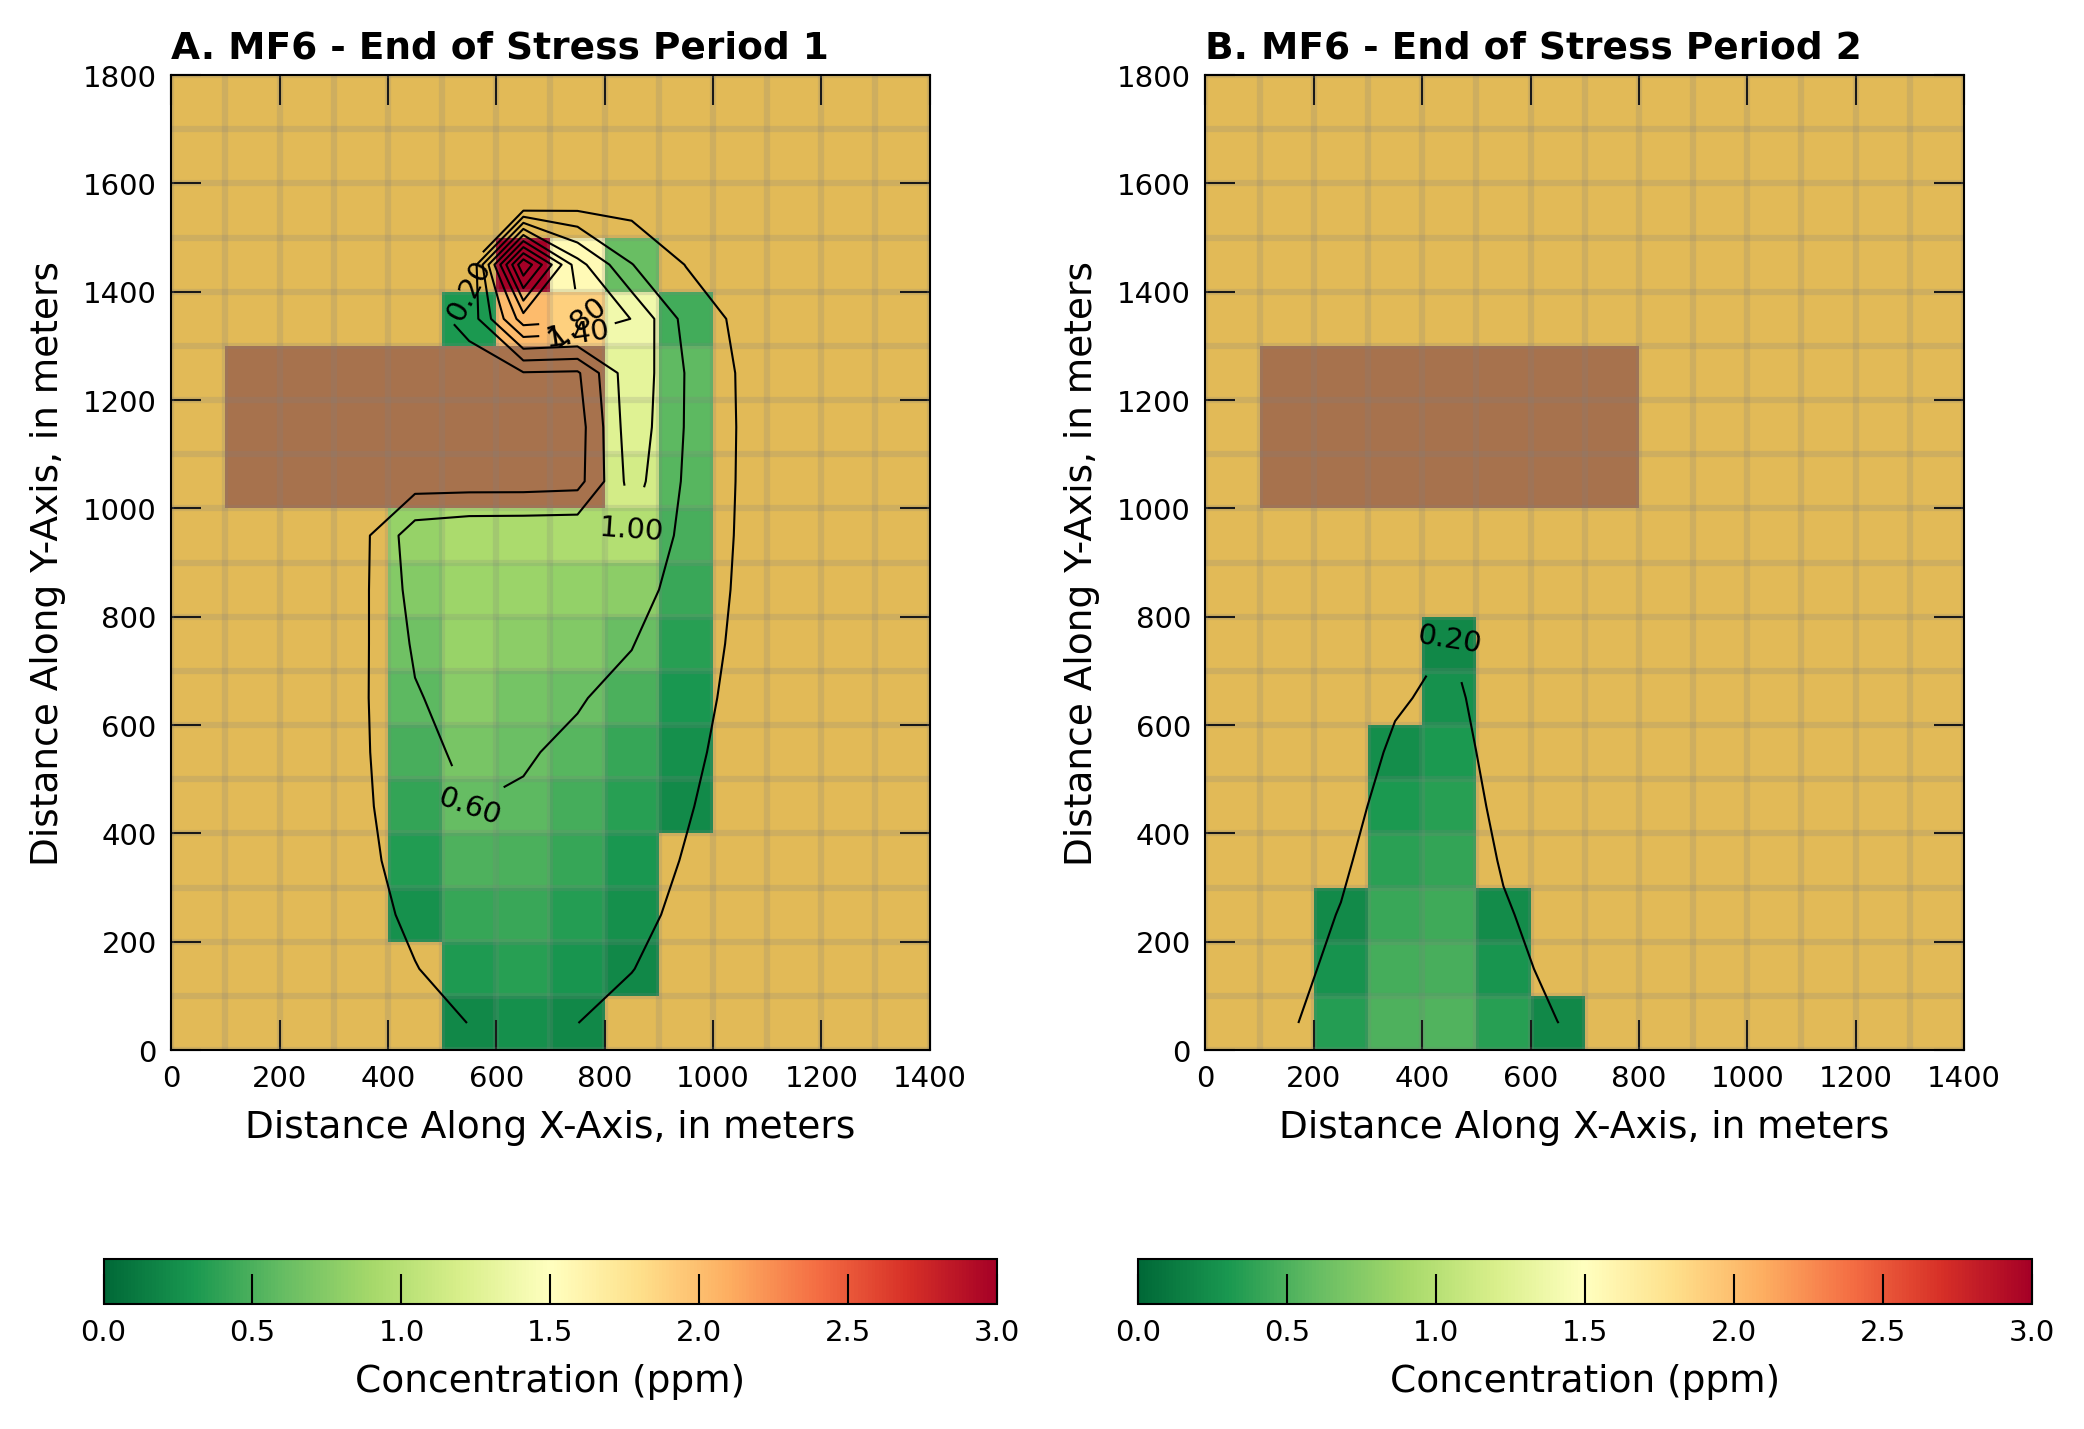

In [28]:
import copy
import matplotlib as mpl
# Figure properties
figure_size = (7, 5)
# Get the MF6 concentration output
gwt = sim.get_model(list(sim.model_names)[1])
ucnobj_mf6 = gwt.output.concentration()
conc_mf6 = ucnobj_mf6.get_alldata()


# Create figure for scenario
with styles.USGSPlot() as fs:
    sim_name = sim.name
    plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
    levels = np.arange(0.2, 10, 0.4)
    stp_idx = 0  # 0-based (out of 2 possible stress periods)
# Plot after 8 years
    axWasNone = False
#    if ax is None:
    fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
    axWasNone = True
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    #mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.8, cmap = cmap)
    mm.plot_array(hk, alpha=0.5, cmap = cmap)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    cs = mm.plot_array(cflood[0],  alpha=1.0, vmin=0, vmax=3, cmap = cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='horizontal')  # Use orientation='horizontal' if preferred
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 0
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)
    
# second stress period
    stp_idx = 1  # 0-based (out of 2 possible stress periods)
    if axWasNone:
        ax = fig.add_subplot(1, 2, 2, aspect="equal",label = "subplot2")
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    #mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.8, cmap = cmap)
    mm.plot_array(hk, alpha=0.5, cmap = cmap)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    cs = mm.plot_array(cflood[0], alpha=1.0, vmin=0, vmax=3, cmap = cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='horizontal')  # Use orientation='horizontal' if preferred
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 1
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)

    plt.show()

In the figures above, the brown rectangle contained within the goldenrod rectangle represent two different horizontal hydraulic conductivities. The goldenrod color represents the conductivity of a medium grain material, $K_1 = 1.474\times 10^{-4}~\frac{m}{sec}$. The brown color represents theconductivity of a fine grain material, $K_2 = 1.474 \times 10^{-7}~\frac{m}{sec}$.

The plume "color map" is overlain on the material property map, and is set to opaque (not transparent).  The color ramp is and inverted GreenYellowRed.  High values render as red, lowest as green.

## Summary

By reverse engineering MT3DMS Example 9 in **MODFLOW 6 (GWT)**, we now have a repeatable workflow to:
- build a coupled **flow (GWF)** + **transport (GWT)** model with FloPy,
- run it, extract results, and
- verify behavior against a well-known benchmark.

You can now explore more complex scenarios with confidence—changing advection/dispersion settings, sources/sinks, and boundary conditions—while keeping the same build → run → postprocess → verify pattern.

### Things to Try next (hands-on)
- **Flow vectors (quiver):** compute **specific discharge** and plot arrows to visualize directions.
- **Breakthrough curves:** extract **C(t)** at one or more wells/cells and compare to MT3DMS curves.
- **Mass balance:** track total mass in system (sources − sinks − storage change) to diagnose leakage or BC mistakes.
- **Sensitivity & grids:** vary dispersivities, decay, sorption (retardation), and refine Δx, Δy, Δt to check grid/time-step dependence.

### Quiver plot quick-start (MF6 structured grid)

Naturally need to identify actual object names and modify - we will try live-in-class.

```python
import flopy as fp

t = list(gwf.output.head().get_times())[0]          # pick a time (or set explicitly)
head = gwf.output.head().get_data(totim=t)

cbc = gwf.output.budget()
frf = cbc.get_data(text="FLOW RIGHT FACE", totim=t)[0]   # q across i→i+1 faces
fff = cbc.get_data(text="FLOW FRONT FACE", totim=t)[0]   # q across j→j+1 faces

# Specific discharge (Darcy velocity) qx, qy from face flows (layer 0 shown)
from flopy.utils.postprocessing import get_specific_discharge
qx, qy, _ = get_specific_discharge((frf, fff, None), delr=delr, delc=delc, top=top, botm=botm)

pmv = fp.plot.PlotMapView(model=gwf)
pmv.plot_array(head[0])
pmv.plot_vector(qx[0], qy[0], normalize=True, color="k", scale=25)  # normalize=True for direction emphasis
pmv.plot_grid(alpha=0.1)
```

:::{tip}
LLM copilots (including free tiers) are great for plotting and postprocessing. Tell the model what arrays you have (e.g., head, FLOW RIGHT FACE, FLOW FRONT FACE, conc) and what you want to see (quiver, breakthrough at cell (i,j), filled contours, log-scaled colorbar). It will usually sketch a working snippet you can paste and adapt.
:::

# MF6–GWT compared to USGS-MOC Benchmark

This sub-section extends our MODFLOW 6 Groundwater Transport (GWT) workflow by **replicating a classic USGS-MOC benchmark** from the 1980s. We follow the setup described here and compare MF6 results to the published MOC solution:
<http://54.243.252.9/ce-5364-webroot/ce5364jupyterbook/_build/html/chapters/12.02usgsmocmodel/usgsmoc.html>

**Why this example?**  
It’s a verifiable, historically important case that lets us check MF6–GWT against a legacy standard while reinforcing the **build → run → postprocess → verify** pattern.

**Goals**
- Configure a coupled **GWF+GWT** model for a simple advection/dispersion scenario inspired by USGS-MOC.  
- Set advection and dispersion parameters, run MF6, and extract plume snapshots and **breakthrough curves**.  
- **Compare** MF6 results to MOC expectations and explain any differences (grid resolution, time step, numerical diffusion).

**What to verify**
- **Direction & shape:** plume aligns with the velocity field and broadens with dispersivity as expected.  
- **Arrival times:** BTC peaks at observation points match the benchmark within reasonable numerical tolerance.  
- **Conservation:** mass balance closes; no negative concentrations; results are stable under modest Δx/Δt refinement.

:::{note}
Expect small differences from the original MOC plots due to discretization choices and MF6 numerics (e.g., upwinding vs. MOC’s characteristics-based advection). The goal is **consistency in behavior and trends**, not pixel-perfect matching.
:::


## Problem Statement:

Alluvial valley with lakes as shown. Mountains are hydrogeologic barriers. Region is arid.

Problem: Fuel spill at parking area near Lake 1 introduces contamination at 100 mg/l over area shown; How will plume spread over time?

![](example1-area.png)

### Conceptual model:

- Assume 2D confined flow approximation is valid (small drawdowns compared to saturated thickness)
- No pumping
- Recharge = Evaporation (so net rainfall to aquifer is negligible)
- Mountains are no-flow boundaries.

Translate into a computational grid:

![](concept2grid.png)

Using the sketch above we can construct a MODFLOW6 Flow and Transport model to study the question. 

:::{note}
Literally we will simply modify the working model already created to fit the situation.  If you end up doing these (models) a lot, much can be automated, but only a handful of people actually become modelers full time and once they get good they get promoted to supervisory roles so their skills can atrophy.
:::

In [29]:
%reset -f

In [30]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The script generates a lot of output that are suppressed by a `;`  Comment the character out to re-enable full output (which is damn helpful for debugging the script!)
:::

## Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [31]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The code block above loads various modules into the environment; they must exist and be loaded into the kernel - if not you get a warning "Module Not Found" and will have to install into the kernel (i.e. `pip -m install module`, or the `conda` equivalent
Filter warnings repeated to achieve "for sure ..." that the filter is applied.  By design the filter will not stop ERRORS, and warnings issued within functions will still display, but it will address one annoying deprecation error.
:::

### Define parameters

Define model units, parameters and other settings.

In [32]:
# Model units
length_units = "feet"
time_units = "seconds"

# Model parameters
nlay = 1  # Number of layers
nrow = 7  # Number of rows
ncol = 7  # Number of columns
delr = 900.0  # Column width ($ft$)
delc = 900.0  # Row width ($ft$)
delz = 20.0  # Layer thickness ($ft$)
top = 0.0  # Top of the model ($ft$)
prsity = 0.3  # Porosity
k1 = 0.005  # Horiz. hyd. conductivity of medium grain material ($m/sec$)
inj = 0.001  # Injection well rate ($ft^3/sec$) - no wells this model
ext = -0.001  # Extraction well pumping rate ($ft^3/sec$) - no wells this model
al = 90.0  # Longitudinal dispersivity ($ft$)
trpt = 0.3  # Ratio of horiz. transverse to longitudinal dispersivity 
perlen = 2.0  # Simulation time ($years$)
## Values above are same as conceptual model in figure 

# Additional model input
hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
#hk[:, 5:8, 1:8] = k2 only one layer type this case
laytyp = icelltype = 0

# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[0, 0, 4:7] = -1
ibound[0, -1, 0:3] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions
# MF2K5 pumping info
qwell1 = 0.001
qwell2 = -0.0189
welspd = {0: [[0, 3, 6, qwell1], [0, 10, 6, qwell2]]}  # Well pumping info for MF2K5
cwell1 = 0.0
cwell0 = 0.0
spd = {
    0: [[0, 3, 6, cwell1, 2], [0, 10, 6, cwell0, 2]],
    1: [[0, 3, 6, cwell0, 2], [0, 10, 6, cwell0, 2]],
}  # Well info 4 MT3D
# MF6 pumping information
wellist_sp1 = []
#                   (k,  i, j),   flow,  conc
wellist_sp1.append([(0, 3, 6), qwell1, cwell1])  # Injection well
wellist_sp1.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
#
wellist_sp2 = []
#                   (k,  i, j),   flow,  conc
wellist_sp2.append([(0, 3, 6), qwell1, cwell0])  # Injection well
wellist_sp2.append([(0, 10, 6), qwell2, cwell0])  # Pumping well
spd_mf6 = {0: wellist_sp1, 1: wellist_sp2}

# Transport related
sconc = 0.0
ath1 = al * trpt
dmcoef = 90.0  # m^2/s
# Time variables
perlen = [365.0 * 86400, 365.0 * 86400]
steady = [False, False]
nper = len(perlen)
nstp = [365, 365]
tsmult = [1.0, 1.0]
#
sconc = 0.0
c0 = 0.0
botm = [top - delz]
mixelm = -1

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

The code block above loads variables and constants to define the actual model.  We will focus on how to conceptualize later on.

:::{admonition} **Assumption**
I have assumed that the code surrounds the entire model domain with no-flow cells; it's what I would do in a general purpose program.  I don't know and the [MODFLOW6](https://pubs.usgs.gov/publication/tm6A57) report is kind of vague on the underlying technical approach; so I choose to make a guess and see how far I get - this is typical when learning how to operate a program, your mileage may vary
:::

:::{admonition} *Update*
The model indeed surrounds the computation domain with the equivalent of no-flow conditions as per

![](noflow.png)

Descriped on pg. 41 of [Documentation for the MODFLOW 6 Groundwater Flow Model, Ch 55, Book A6](https://pubs.usgs.gov/tm/06/a55/tm6a55.pdf)
:::

In [33]:
ibound

array([[[ 1,  1,  1,  1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1],
        [-1, -1, -1,  1,  1,  1,  1]]])

## Model setup

Define functions to build models, write input files, and run the simulation.

**Groundwater Flow Package Build**

In [34]:
# Workspace and Executibles
#binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
#workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6_moc1" # location on MY computer to store files this example (directory must already exist)
#workarea = workspace # location on MY computer to store files this example (directory must already exist)

binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on AWS computer of the compiled modflow program
workarea = "/home/sensei/ce-5364-webroot/mfexperiments/mf6-ex2" # location on MY computer to store files this example (directory must already exist)


# Set Simulation Name(s)
name = "mf6_moc1"
gwfname = "gwf-" + name
gwtname = "gwt-" + name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name="sim-" + name, exe_name=binary, version="mf6", sim_ws=workarea
)
####### CREATED "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mt3d_example9"

The code block above sets paths to the binary (in my case a compiled MODFLOW6 object located at `/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/`.   The binary was built using the `make` utility operating on the `makefile` contained in `~path_to_source/mf6.4.1_linux/make`

In [35]:
####### Instantiating MODFLOW 6 time discretization ########
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units);
## delete ";" in above line at end to show full output

The code block above sets the time stepping structure.  Units are supplied in the model constants already created. `perlen` is a list of period length in time units of a stress period. , `nstp` is a list of the number of time steps per period, tsmult is a list of time step multipliers.

In [36]:
####### Instantiating MODFLOW 6 groundwater flow model ########
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(gwfname)
# create MODFLOW6 flow model framework
gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True, model_nam_file=model_nam_file)
## delete ";" in above line at end to show full output

The code block above sets prefix of the flow model file names.  

In [37]:
###### Instantiating MODFLOW 6 solver for flow model #######
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwfname}.ims",
    )
sim.register_ims_package(imsgwf, [gwf.name]);
## delete ";" in above line at end to show full output

The code block above sets the iteration and solver parameters.  URL to documents is included in the comments.

In [38]:
###### Instantiating MODFLOW 6 discretization package ######
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    );
## delete ";" in above line at end to show full output

The code block above sets the spatial structure.  We must supply layers, rows, columns, and spacing between rows and columns (i.e. how big is a pixel).  Vertical spacing computed as 

$$\Delta z = \frac{\text{top}-\text{bottom}}{\text{number of layers}}$$

In [39]:
###### Instantiating MODFLOW 6 initial conditions package for flow model #######
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, 0, 4:7] = 100.0 # set top row t0 100
xc = gwf.modelgrid.xcellcenters
strt[0, -1, 0:3] = 80.0 # set bottom row to 80
flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
## delete ";" in above line at end to show full output

package_name = ic
filename = gwf-mf6_moc1.ic
package_type = ic
model_or_simulation_package = model
model_name = gwf-mf6_moc1

Block griddata
--------------------
strt
{internal}
(array([[[  0.,   0.,   0.,   0., 100., 100., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 80.,  80.,  80.,   0.,   0.,   0.,   0.]]]))



The code block above sets the initial conditions. The top row in this example is set to 100, the bottom row to 80.0.  If there are other starting conditions either write code or read from a file, or hard-code the constants as needed.

In [40]:
# Instantiating MODFLOW 6 node-property flow package
flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=hk,
    k33=hk,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    );
## delete ";" in above line at end to show full output

The code block above sets the node-property data (its like the old BCF package).  Here we supply that we want to save sp. discharge (needed for transport), the k, and k33 values the same implies NOT unconfined sustem.

In [41]:
# Instantiate storage package
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.0e-05);
## delete ";" in above line at end to show full output

The code block above sets the storage properties for transient simulations.

In [42]:
# Instantiating MODFLOW 6 constant head package
# MF6 constant head boundaries:
chdspd = []
# Loop through the top & bottom sides.
for j in range(4,7):
        #               l,  r, c,  head, conc
    chdspd.append([(0, 0, j), 100.0, 0.0])  # Top boundary
for j in range(0,3):
    chdspd.append([(0, 6, j), 80.0, 0.0])  # Bottom boundary
chdspd = {0: chdspd}

flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    );
## delete ";" in above line at end to show full output

The code block above sets the constant head boundary conditions.

:::{note}
I have intentionally supressed the well package for this example; it should still work because its MODULAR!
:::


In [43]:
# Instantiating MODFLOW 6 output control package for flow model
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    );
## delete ";" in above line at end to show full output

The code block above defines parts of output control.



**Transport Package Building**

In [44]:
###### Instantiating MODFLOW 6 groundwater transport package ##########
gwtname = "gwt-" + name
gwt = flopy.mf6.MFModel(
    sim,
    model_type="gwt6",
    modelname=gwtname,
    model_nam_file=f"{gwtname}.nam",
    )#;
## delete ";" in above line at end to show full output
gwt.name_file.save_flows = True

The code block above sets prefix of the transport model file names.  

In [45]:
# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwtname}.ims",
    )
sim.register_ims_package(imsgwt, [gwt.name])#;
## delete ";" in above line at end to show full output

The code block above sets the iteration and solver parameters.  

In [46]:
###### Instantiating MODFLOW 6 transport discretization package #####
flopy.mf6.ModflowGwtdis(
    gwt,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    );
## delete ";" in above line at end to show full output

The code block above sets the spatial structure.  We must supply layers, rows, columns, and spacing between rows and columns (i.e. how big is a pixel).  Vertical spacing computed as 

$$\Delta z = \frac{\text{top}-\text{bottom}}{\text{number of layers}}$$

Typically will be same as flow model.

In [47]:
# Instantiating MODFLOW 6 transport initial concentrations
sconc = np.zeros((nlay, nrow, ncol), dtype=float)
sconc[0, 1, 3:7] = 100.0 # set fuel spill row
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
## delete ";" in above line at end to show full output

package_name = ic
filename = gwt-mf6_moc1.ic
package_type = ic
model_or_simulation_package = model
model_name = gwt-mf6_moc1

Block griddata
--------------------
strt
{internal}
(array([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 100., 100., 100., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.]]]))



Initial conditions (concentration) for transport.

In [48]:
    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv");
## delete ";" in above line at end to show full output

Advective transport methods.  In this example upwind formulation with Total Variation Diminishing (TVD) flux limiters. A TVD formulation is a numerical method designed to ensure that the computed solution to a transport equation does not exhibit non-physical oscillations or spurious oscillations, particularly near discontinuities or steep gradients. This flux limitation is crucial for maintaining the accuracy and stability of the numerical solution in simulations involving advective transport, such as contaminant transport in groundwater models.

Key points about TVD formulations:

- Purpose: TVD methods aim to prevent the introduction of oscillations or artifacts in the numerical solution that can arise from the discretization of the transport equation, especially in regions with sharp gradients or discontinuities.

- Techniques: TVD schemes use various strategies to achieve this, including modifying the standard discretization approaches, using flux limiters, or applying specific numerical flux functions that ensure the total variation of the solution is not increased.

- Applications: TVD methods are commonly used in computational fluid dynamics, meteorology, and environmental modeling where accurate representation of transport processes is essential. In groundwater modeling, TVD formulations help to ensure realistic simulation of contaminant transport and avoid numerical artifacts that could lead to incorrect predictions.

- Examples: Common TVD schemes include the TVD Runge-Kutta methods, TVD Lax-Wendroff schemes, and various other high-resolution schemes that incorporate flux limiters or other modifications to ensure total variation diminishing properties.

In [49]:
# Instantiating MODFLOW 6 transport dispersion package
if al != 0:
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al, # longitudinal
        ath1=ath1, # transverse
        filename=f"{gwtname}.dsp",
        );
## delete ";" in above line at end to show full output

This code iniatiates the dispersion method with Longitudinal dispersivity  $a_l = 20.0~m$ and the ratio of horizontal transverse to longitudinal dispersivity $trpt = 0.2$  In the above script $a_t = trpt \times a_l$

In [50]:
# Instantiating MODFLOW 6 transport mass storage package
flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=prsity,
    first_order_decay=False,
    decay=None,
    decay_sorbed=None,
    sorption=None,
    bulk_density=None,
    distcoef=None,
    filename=f"{gwtname}.mst",
    );
## delete ";" in above line at end to show full output

Code block sets adsorbtion/desorbtion and 1st order decay terms if any.

In [51]:
# Instantiating MODFLOW 6 transport source-sink mixing package
#sourcerecarray = [
 #   ("WEL-1", "AUX", "CONCENTRATION"),
  #  ("CHD-1", "AUX", "CONCENTRATION"),
   # ]
sourcerecarray = [
    ("CHD-1", "AUX", "CONCENTRATION"),
    ]
flopy.mf6.ModflowGwtssm(
    gwt,
    sources=sourcerecarray,
    print_flows=True,
    filename=f"{gwtname}.ssm",
    );
## delete ";" in above line at end to show full output

Code above manages source/sink mixing terms.

In [52]:
# Instantiating MODFLOW 6 transport output control package
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwtname}.cbc",
    concentration_filerecord=f"{gwtname}.ucn",
    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    filename=f"{gwtname}.oc",
    );
## delete ";" in above line at end to show full output

Output control for transport

In [53]:
# Instantiating MODFLOW 6 flow-transport exchange mechanism
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwfname,
    exgmnameb=gwtname,
    filename=f"{name}.gwfgwt",
    );
## delete ";" in above line at end to show full output

Code above manages how flow (gwf) and transport (gwt) exchange information at each time step.

**Generate the Files**

In [54]:
sim.write_simulation(silent=True)

**Running the Model** 

In [55]:
#success, buff = sim.run_simulation(silent=False, report=True)#Verbose output
success, buff = sim.run_simulation(silent=True, report=True)#Suppress output
assert success, pformat(buff)

### Plotting results

Plotting model results.

:::{note}
Even more reverse engineering to produce plots; took a fair bit of reading on the mighty internet to hack these plots.  We will compare to the elderly USGS-MOC code for the same problem.
:::

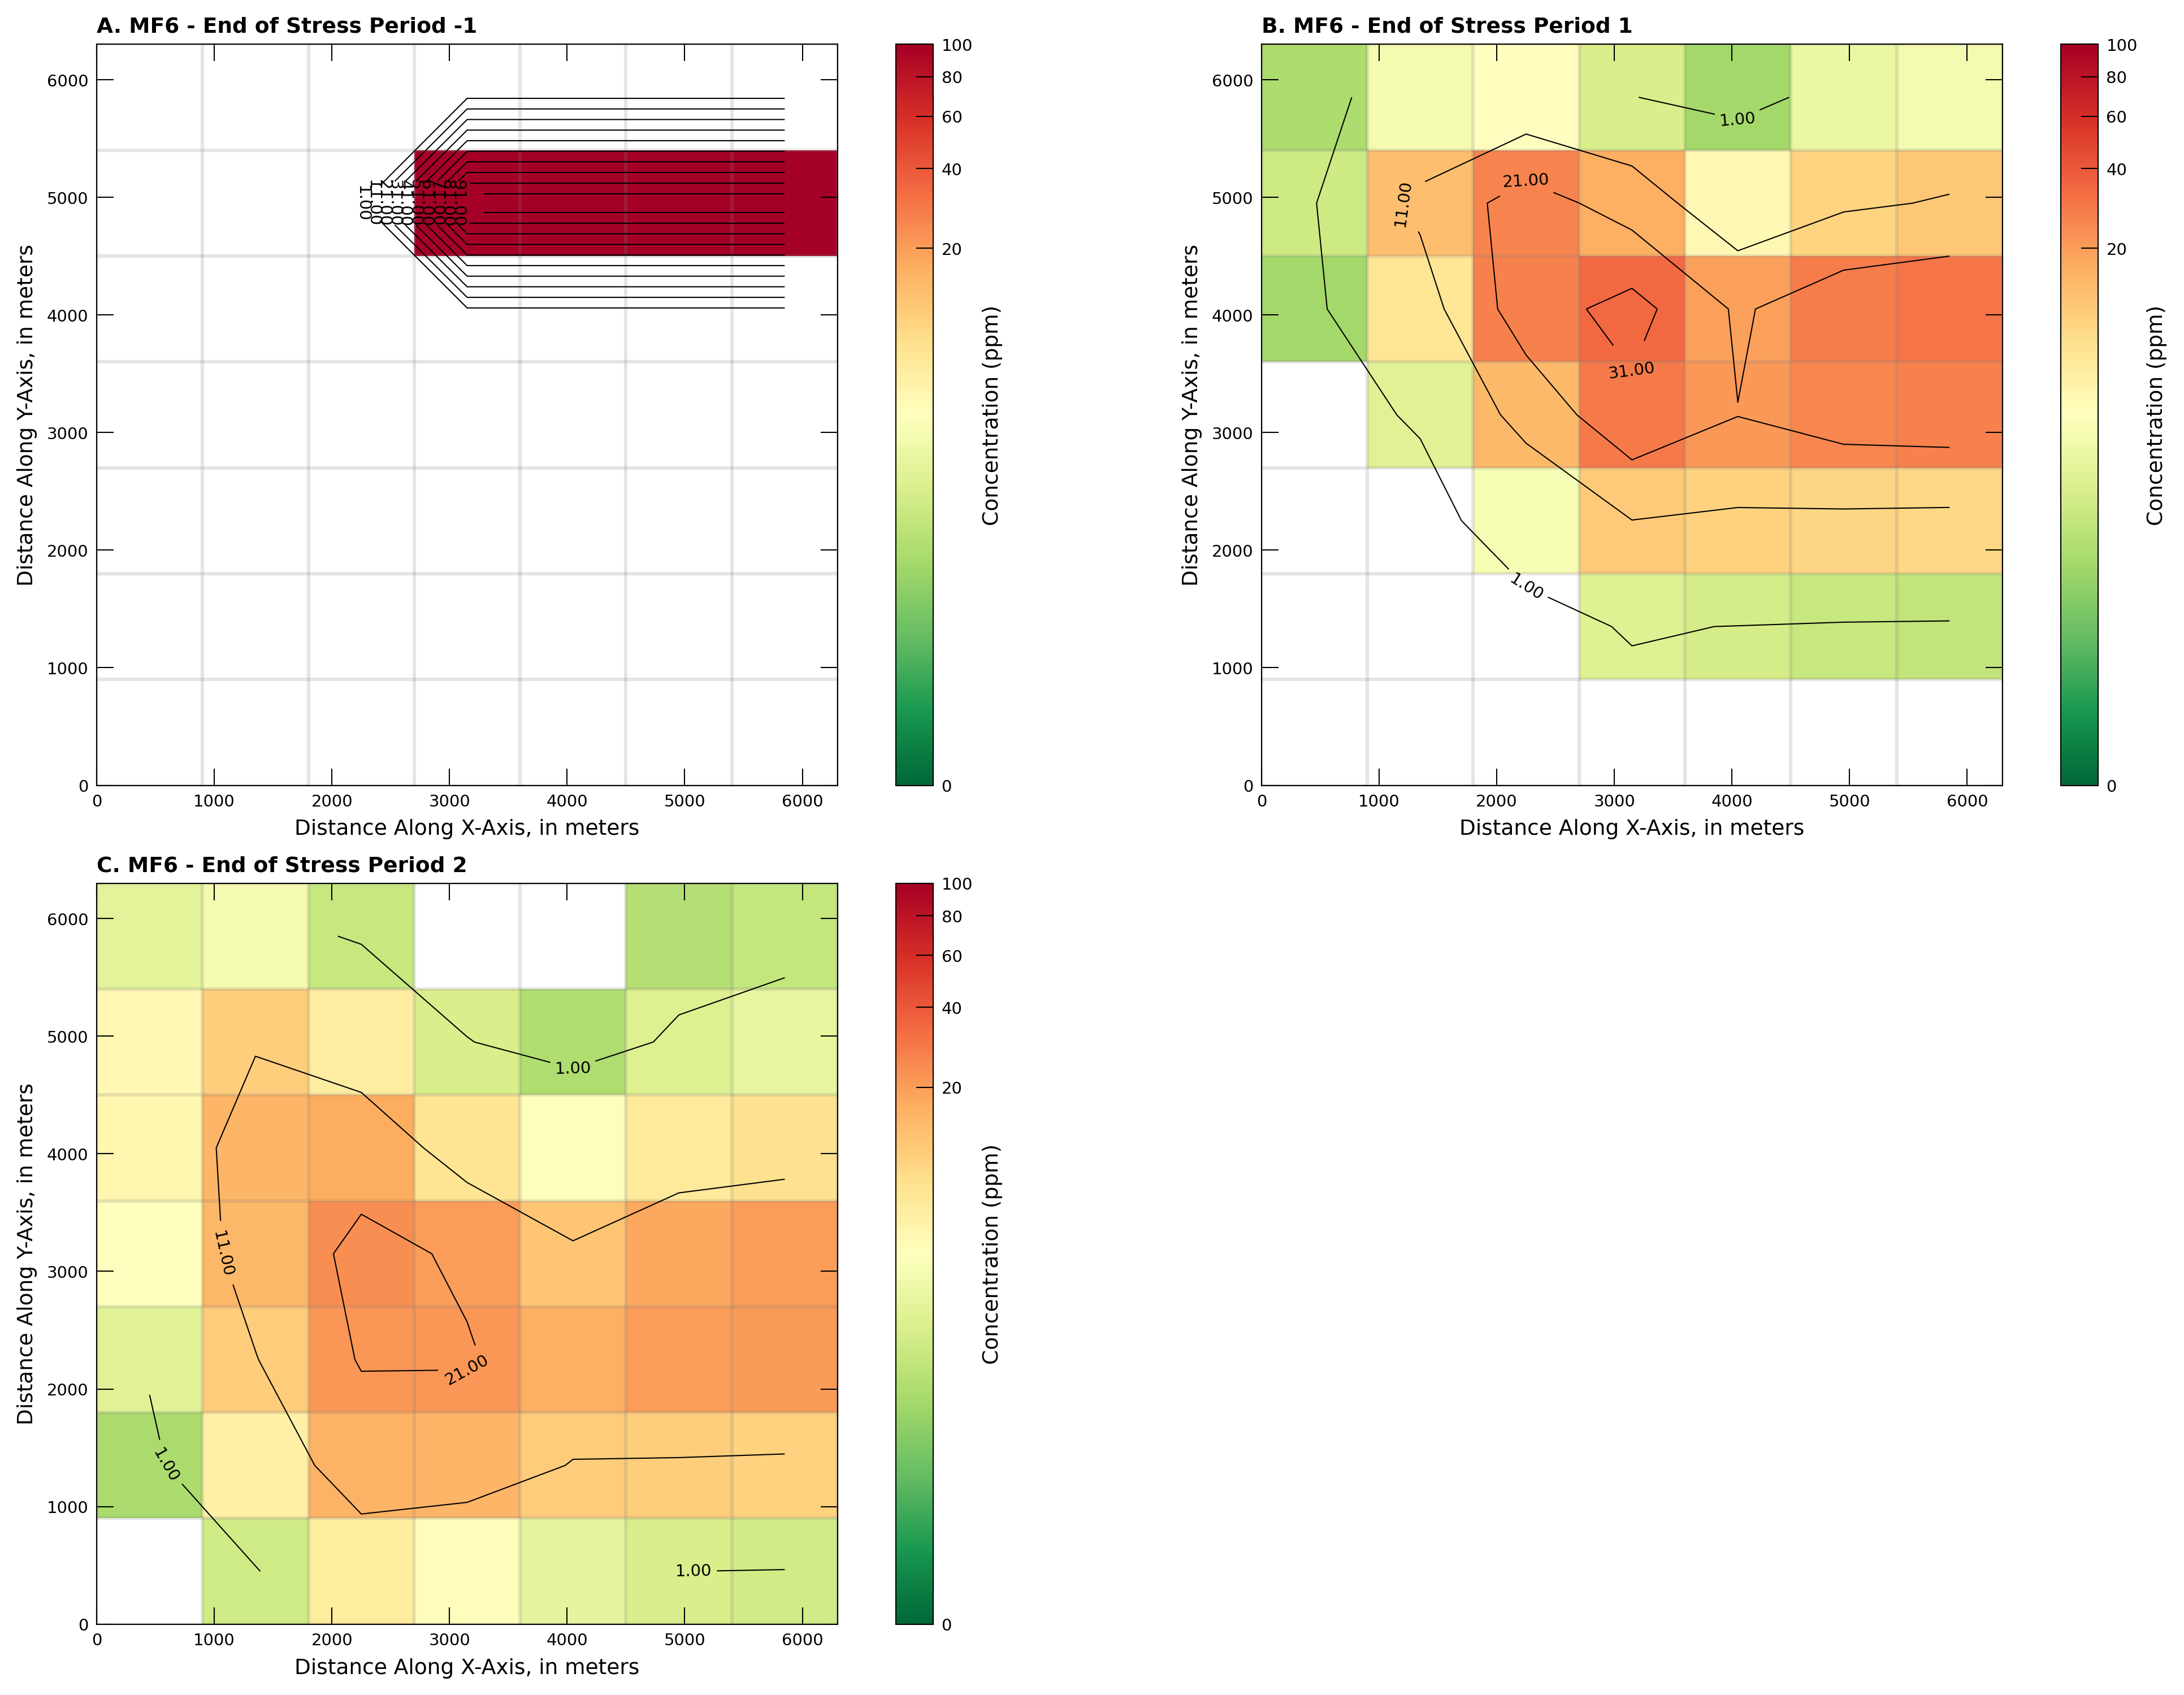

In [56]:
import copy
import matplotlib as mpl
import matplotlib.colors as mcolors
# Figure properties
figure_size = (14, 10)
# Get the MF6 concentration output
gwt = sim.get_model(list(sim.model_names)[1])
ucnobj_mf6 = gwt.output.concentration()
conc_mf6 = ucnobj_mf6.get_alldata()


# Create figure for scenario
with styles.USGSPlot() as fs:
    sim_name = sim.name
    plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
    levels = np.arange(1.0, 100., 10.0)
    
# end stress period -1 (initial conditions)
################################ Initial Conditions (notice the cflood object uses sconc array)#################
    axWasNone = False
    fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
    axWasNone = True
    ax = fig.add_subplot(2, 2, 1, aspect="equal")  ### 2X2 Plot matrix, this is upper left
    cflood = np.ma.masked_less_equal(sconc, 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    cmap.set_bad(color='none')
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    cmap.set_bad(color='none')
# Adjust normalization to skew values towards green
    norm = mcolors.PowerNorm(gamma=0.2, vmin=0, vmax=100)  # Lower gamma pushes towards green
# Plot using the adjusted normalization
    cs = mm.plot_array(cflood[0], alpha=1.0, norm=norm, cmap=cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(sconc, colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(-1)
# set idx
    idx = 0
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)
################################## Results From Simulation ##########################    
# end stress period 0
    stp_idx = 0  # 0-based (out of 2 possible stress periods)
    axWasNone = True
    ax = fig.add_subplot(2, 2, 2, aspect="equal") ### 2X2 Plot matrix, this is upper right
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    cmap.set_bad(color='none')
# Adjust normalization to skew values towards green
    norm = mcolors.PowerNorm(gamma=0.2, vmin=0, vmax=100)  # Lower gamma pushes towards green
# Plot using the adjusted normalization
    cs = mm.plot_array(cflood[0], alpha=1.0, norm=norm, cmap=cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 1
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)
    
# end stress period 1
    stp_idx = 1  # 0-based (out of 2 possible stress periods)
    if axWasNone:
        ax = fig.add_subplot(2, 2, 3, aspect="equal",label = "subplot2") ### 2X2 Plot matrix, this is lower left
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    cmap.set_bad(color='none')
# Adjust normalization to skew values towards green
    norm = mcolors.PowerNorm(gamma=0.2, vmin=0, vmax=100)  # Lower gamma pushes towards green
# Plot using the adjusted normalization
    cs = mm.plot_array(cflood[0], alpha=1.0, norm=norm, cmap=cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 2
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)
    plt.show()
### 2X2 Plot matrix, lower right is null

The plume "color map" is overlain on the computational grid, and is set to opaque (not transparent).  The color ramp is and inverted GreenYellowRed.  The scale bar is distorted to emphasize concentrations bigger than 10.0 ppm in the plot call. High values render as red, lowest as green, the white cells are strict zero (there is no constituient mass in those cells yet.

## Comparison

The original MOC model output that corresponds to "Panel C" above is

![](MOCout.png)

Here is a script to try to generate a similar plot for comparison

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_contour_from_array(
    Z,
    x0=0.0, y0=0.0, dx=1.0, dy=1.0,
    levels=12,
    filled=True,
    mask_boundary=False,
    show_points=False,
    cmap="RdYlGn_r",
    title="Concentration contour",
    cbar_label="z",
    save=None,
    y_flip=False,        # NEW: flip row order (first row drawn at top)
    invert_yaxis=False   # NEW: keep data as-is, just invert axis direction
):
    """
    Plot a contour map from a 2D array Z (ny x nx).

    y_flip=True  -> flips the data along Y (use when you fed rows in top-to-bottom order)
    invert_yaxis -> only flips the axis direction (use when data order is correct but
                    you want y increasing downward to match another plot)
    """
    Z = np.asarray(Z, dtype=float)
    ny, nx = Z.shape

    # Coordinates at nodes (origin at lower-left node)
    x = x0 + np.arange(nx) * dx
    y = y0 + np.arange(ny) * dy
    X, Y = np.meshgrid(x, y)

    # Optionally flip data along Y (top-bottom)
    Zplot = Z[::-1, :] if y_flip else Z.copy()

    # Optionally mask off the outer boundary ring
    if mask_boundary:
        Zplot = Zplot.astype(float)
        Zplot[0,  :] = np.nan
        Zplot[-1, :] = np.nan
        Zplot[:,  0] = np.nan
        Zplot[:, -1] = np.nan

    fig, ax = plt.subplots(figsize=(6.5, 5.5))

    zmin = np.nanmin(Zplot); zmax = np.nanmax(Zplot)
    # Filled contours
    if filled:
        cf = ax.contourf(X, Y, Zplot, levels=levels, alpha=0.7, cmap=cmap)             # + norm=... if you use one
        cbar = fig.colorbar(cf, ax=ax, shrink=0.9)
        cbar.set_label(cbar_label)

    # Black contour lines on top (same levels as fill)
    cs = ax.contour(X, Y, Zplot, levels=levels, colors='k', linewidths=0.8)

    # Black contour labels
    ax.clabel(cs, fmt='%.2f', colors='k', inline=True, fontsize=8)

    
#    cs = (ax.contourf if filled else ax.contour)(X, Y, Zplot, levels=levels, cmap=cmap)
#    plt.clabel(cs, fmt='%.2f')
#    cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
#    cbar.set_label(cbar_label)

    if show_points:
        ax.scatter(X.ravel(), Y.ravel(), s=15, c="k", alpha=0.5, label="nodes")
        ax.legend(loc="best")

    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    if invert_yaxis:
        ax.invert_yaxis()  # flip axis direction without changing data
    ax.set_aspect("equal" if np.isclose(dx, dy) else "auto", adjustable="box")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches="tight")
    plt.show()
    return ax


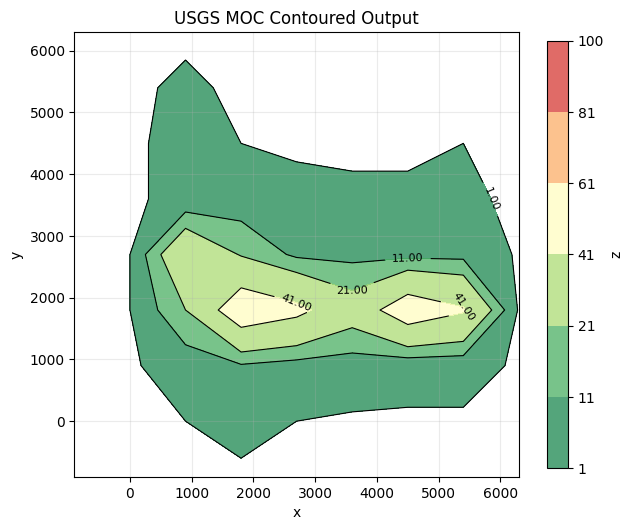

In [58]:
# ----------------------------
# Example with the 9x9 values
# ----------------------------
Z_data = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 1, 0, 0, 0, 1, 0],
    [0, 0, 3, 5, 3, 2, 2, 2, 0],
    [0, 1, 37, 20, 9, 8, 8, 8, 0],
    [0, 1, 21, 55, 46, 28, 54, 43, 0],
    [0, 0, 5, 10, 7, 6, 4, 4, 0],
    [0, 0, 1, 3, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=float)

plot_contour_from_array(
    Z_data, x0=-900, y0=-900, dx=900, dy=900,
    levels=[1,11,21,41,61,81,100],
    #levels = 10,
    filled=True, show_points=False,
    y_flip=True,           # fix row order
    invert_yaxis=False,    # or True if you just want axis reversed
    mask_boundary=False,    # mask boundary rows/columns
    cmap = "RdYlGn_r",
    save = "moc-out-plot.png" ,
    title="USGS MOC Contoured Output"
);


Here are the two model outputs side-by-side:

<!--<div style="display:flex; gap:10px; justify-content:center; align-items:flex-start;">
  <img src="GWTclip.png" alt="MF6–GWT" style="width:47%; height:auto;">
  <img src="moc-out-plot.png" alt="MOC" style="width:47%; height:auto;">
</div>-->

![](side-by-side.png)

## Summary

The plume patterns are similar and the magnitudes are reasonably close. To confirm that MF6–GWT is truly reproducing the legacy case, the next step would be a short verification pass:

- **Inputs match:** same grid/coordinates, BCs/ICs, sources/sinks, advection scheme, dispersivities (and decay/sorption if used), and time stepping.
- **Apples-to-apples outputs:** compare at the **same nodes/cells** and **same times**; ensure plotting uses identical levels/colormaps.
- **Conservation checks:** mass balance closes over the comparison window.

(Optional) add simple **quantitative metrics**:
- Field error at snapshot times (e.g., RMSE over cells).
- Breakthrough timing/peak error at observation points.
- Mass error \(\le\) a small tolerance (e.g., <1–3%).

Given the current agreement, we’ll proceed and treat this as an **acceptable validation** and a **reusable workflow** for MF6 flow + transport: *build → run → postprocess → verify → iterate*.


:::{admonition} **Numerics at a glance.**  
MF6–GWT uses an upwind-family discretization (here with a TVD flux limiter), whereas the legacy MOC uses a method-of-characteristics treatment for advection. We’ve already coded a basic upwind solver in the advection section, and—with time—you could extend it to include velocity-dependent dispersivity, adsorption (LEA), first-order decay, and distributed sources/sinks.

- Production vs. tinkering: MF6–GWT already implements these features, is well-tested, and is widely accepted for professional use—so it’s the better default. Write your own only when you need nonstandard chemistry/kinetics, unusual couplings (e.g., reactive plume–plume interactions beyond built-ins), or for research/teaching.
- If you do roll your own, verify aggressively:  The burden shifts to you. Use a quick checklist:
  - Reproduce published benchmarks (e.g., MT3DMS, USGS-MOC) and compare snapshots/BTCs.
  - Check mass conservation and nonnegativity of concentrations.
  - Do grid and time-step refinement (convergence trends).
  - Respect CFL/Péclet limits; document stability settings.
  - Where possible, test against manufactured solutions or closed-form cases.
- Encouragement:  By all means experiment—it’s a great way to learn the numerics. Just keep MF6–GWT as a reference baseline and fall-back tool while you explore.
:::
